In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/character_extraction_dataset.zip

In [ ]:
!pip install ultralytics

In [ ]:
import albumentations as A
from tqdm import tqdm
from ultralytics import YOLO
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import os
import cv2
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
class CEDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):

        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        label_path = os.path.join(self.label_dir, image_name.lower().replace('.jpg', '.txt'))
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        bboxes = []
        class_ids = []
        if os.path.exists(label_path):

          with open(label_path, 'r') as f:
              lines = f.readlines()

              if not lines:
                  bboxes = []
                  class_ids = []
              else:
                  for line in lines:
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    if all(0 < coord <= 1 for coord in [x_center, y_center, width, height]):
                        class_ids.append(int(class_id))
                        bboxes.append([x_center, y_center, width, height])
        else:
            bboxes = []
            class_ids = []

        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes, class_ids=class_ids)
            image = transformed['image']
            bboxes = transformed['bboxes']
            class_ids = transformed['class_ids']

        #return image, torch.tensor(bboxes, dtype=torch.float32), torch.tensor(class_ids, dtype=torch.int64)
        return image, bboxes, class_ids

base_dataset = CEDataset(
    image_dir="/content/images",
    label_dir="/content/labels",
    transform=None
)

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, augmentations_count, transform1, transform2):
        self.base_dataset = base_dataset
        self.augmentations_count = augmentations_count
        self.dataset_length = len(base_dataset) * (augmentations_count + 1)

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        base_idx = idx // (self.augmentations_count + 1)
        aug_idx = idx % (self.augmentations_count + 1)

        image, bboxes, class_ids = self.base_dataset[base_idx]

        if aug_idx == 0:
          transformed = transform1(image=image, bboxes=bboxes, class_ids=class_ids)
        else:
          transformed = transform2(image=image, bboxes=bboxes, class_ids=class_ids)

        image = transformed['image']
        bboxes = transformed['bboxes']
        class_ids = transformed['class_ids']

        return image, torch.tensor(bboxes, dtype=torch.float32), torch.tensor(class_ids, dtype=torch.int64)

In [ ]:
transform1 = A.Compose([
    A.Resize(768, 768),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']))

transform2 = A.Compose([
    A.Resize(768, 768),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    #A.GaussNoise(var_limit=(10.0, 50.0)),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, min_holes=1, min_height=8, min_width=8, fill_value=0, p=0.5),
    A.Blur(blur_limit=3, p=0.3),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']))

dataset = AugmentedDataset(base_dataset, augmentations_count=6, transform1=transform1, transform2=transform2)
print(f"Размер нового датасета: {len(dataset)}")

Размер нового датасета: 287


<ipython-input-8-92145ead979e>:11: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, min_holes=1, min_height=8, min_width=8, fill_value=0, p=0.5),


In [ ]:
def visualize_image_with_bboxes(image, bboxes, class_ids, class_names=None):

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()

    img_copy = image.copy()

    h, w, _ = img_copy.shape
    for bbox, class_id in zip(bboxes, class_ids):
        x_center, y_center, width, height = bbox
        x_min = int((x_center - width / 2) * w)
        y_min = int((y_center - height / 2) * h)
        x_max = int((x_center + width / 2) * w)
        y_max = int((y_center + height / 2) * h)

        color = (0, 255, 0)
        img_copy = cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color, 2)

        #label = class_names[class_id] if class_names else str(class_id)
        #img_copy = cv2.putText(img_copy, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()

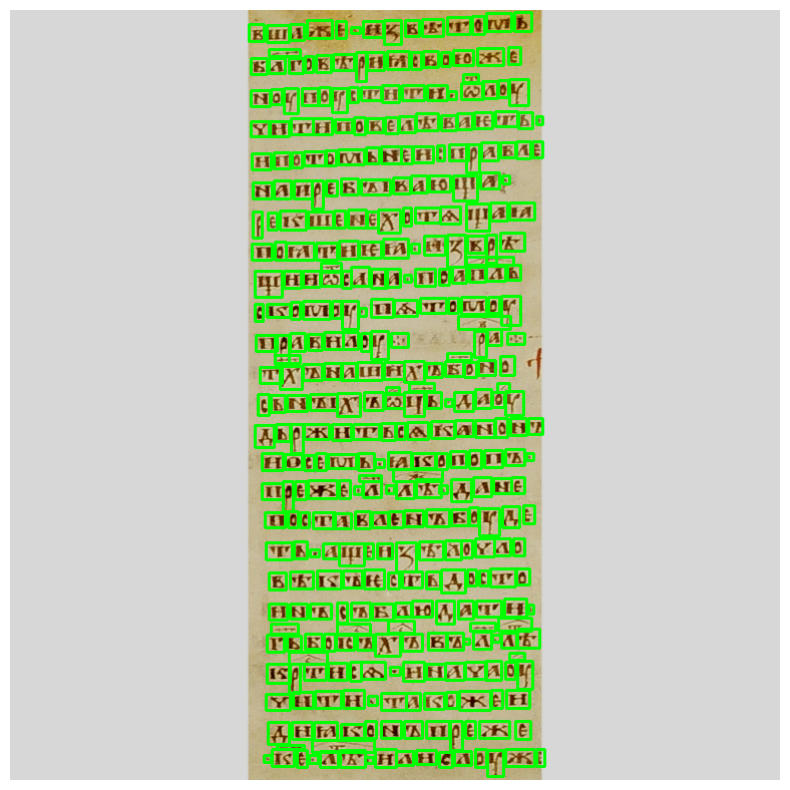

In [ ]:
image, bboxes, class_ids = dataset[243]

visualize_image_with_bboxes(
    image=image,
    bboxes=bboxes.tolist(),
    class_ids=class_ids.tolist(),
    class_names=["text"]
)

In [ ]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size


train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

print(f"Тренировочная выборка: {len(train_dataset)}")
print(f"Валидационная выборка: {len(val_dataset)}")
print(f"Тестовая выборка: {len(test_dataset)}")

Тренировочная выборка: 200
Валидационная выборка: 57
Тестовая выборка: 30


In [ ]:
start_index = 0

output_image_dir = "/content/all_dataset/images"
output_label_dir = "/content/all_dataset/labels"
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

for idx, (image, bboxes, class_ids) in enumerate(tqdm(dataset)):
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_path = os.path.join(output_image_dir, f"{idx + start_index:06d}.jpg")
    cv2.imwrite(image_path, cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))

    label_path = os.path.join(output_label_dir, f"{idx + start_index:06d}.txt")
    with open(label_path, "w") as f:
        for box, class_id in zip(bboxes, class_ids):
            x_center, y_center, width, height = box.tolist()
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

 58%|█████▊    | 166/287 [00:05<00:03, 37.15it/s]/usr/local/lib/python3.11/dist-packages/albumentations/augmentations/dropout/functional.py:309: RuntimeWarning: invalid value encountered in divide
  visibility_ratios = remaining_areas / box_areas
100%|██████████| 287/287 [00:09<00:00, 30.65it/s]


In [ ]:
!zip -r архив7.zip /content/all_dataset

In [ ]:
output_image_dir = "/content/dataset1/images/test"
output_label_dir = "/content/dataset1/labels/test"
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

for idx, (image, bboxes, class_ids) in enumerate(tqdm(test_dataset)):
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_path = os.path.join(output_image_dir, f"{idx:06d}.jpg")
    cv2.imwrite(image_path, cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))

    label_path = os.path.join(output_label_dir, f"{idx:06d}.txt")
    with open(label_path, "w") as f:
        for box, class_id in zip(bboxes, class_ids):
            x_center, y_center, width, height = box.tolist()
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

100%|██████████| 30/30 [00:01<00:00, 20.45it/s]


In [ ]:
model = YOLO('yolov8n.pt')
model.train(
    data='data.yaml',
    epochs=35,
    imgsz=768,
    batch=12,
    project='yolo_training',
    name='augmented_dataset',
    device=0
)

Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=35, time=None, patience=100, batch=12, imgsz=768, save=True, save_period=-1, cache=False, device=0, workers=8, project=yolo_training, name=augmented_dataset6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

100%|██████████| 755k/755k [00:00<00:00, 124MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 270MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1714.1±1062.0 MB/s, size: 118.4 KB)


train: Scanning /content/dataset1/labels/train... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 630.68it/s]

train: New cache created: /content/dataset1/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1113.5±824.0 MB/s, size: 124.8 KB)


val: Scanning /content/dataset1/labels/val... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<00:00, 284.70it/s]

val: New cache created: /content/dataset1/labels/val.cache


Plotting labels to yolo_training/augmented_dataset6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
Image sizes 768 train, 768 val
Using 2 dataloader workers
Logging results to yolo_training/augmented_dataset6
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      14.4G      2.571      3.164      1.123       3324        768: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         57      20855      0.329       0.27      0.345      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      13.9G      2.045      1.619     0.9456       2979        768: 100%|██████████| 17/17 [00:07<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         57      20855      0.767      0.629      0.718       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      14.1G      1.952      1.164     0.9276       3071        768: 100%|██████████| 17/17 [00:07<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         57      20855      0.842       0.69      0.774      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      7.75G      1.917      1.004     0.9242       4300        768: 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         57      20855      0.911      0.747       0.84      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      13.7G      1.898      0.914     0.9227       3934        768: 100%|██████████| 17/17 [00:07<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         57      20855      0.902      0.739      0.841       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      10.8G      1.842     0.8521     0.9145       3332        768: 100%|██████████| 17/17 [00:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         57      20855      0.979      0.802      0.894      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35        12G      1.841     0.8274     0.9139       4633        768: 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         57      20855      0.978      0.802      0.893       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      14.4G      1.798     0.8117     0.9153       3429        768: 100%|██████████| 17/17 [00:07<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         57      20855      0.979      0.803      0.894      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35        13G      1.751     0.7907     0.9033       4967        768: 100%|██████████| 17/17 [00:08<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         57      20855       0.97      0.796      0.885      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      11.7G       1.74     0.7661     0.9038       3813        768: 100%|██████████| 17/17 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         57      20855      0.983      0.806      0.896      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      9.89G      1.717     0.7536     0.9061       4250        768: 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         57      20855      0.985      0.808      0.897      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      13.1G      1.667     0.7396     0.8956       3842        768: 100%|██████████| 17/17 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         57      20855      0.984      0.807      0.897      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      9.41G      1.672     0.7356     0.8936       4094        768: 100%|██████████| 17/17 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         57      20855      0.984      0.807      0.896      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      13.6G      1.659     0.7217     0.8925       4612        768: 100%|██████████| 17/17 [00:07<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         57      20855      0.987      0.809        0.9       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      12.4G      1.671     0.7215     0.8939       3579        768: 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         57      20855      0.986      0.808      0.899      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      7.62G      1.637     0.7112     0.8933       4881        768: 100%|██████████| 17/17 [00:07<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         57      20855      0.988       0.81      0.901      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      10.5G      1.613     0.7079     0.8846       3585        768: 100%|██████████| 17/17 [00:07<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         57      20855      0.991      0.812      0.903      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      12.4G        1.6     0.6957     0.8924       4318        768: 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         57      20855      0.992      0.813      0.904      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35        12G      1.605     0.7099     0.8873       5231        768: 100%|██████████| 17/17 [00:07<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         57      20855      0.984      0.807      0.897      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      12.4G      1.567     0.7049     0.8854       4899        768: 100%|██████████| 17/17 [00:07<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         57      20855       0.99      0.812      0.903      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      11.9G      1.585     0.6929     0.8883       3693        768: 100%|██████████| 17/17 [00:07<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         57      20855      0.989      0.811      0.902      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      9.55G      1.567     0.6898     0.8763       3574        768: 100%|██████████| 17/17 [00:08<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         57      20855      0.989      0.811      0.902       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      12.1G      1.585      0.692     0.8803       4519        768: 100%|██████████| 17/17 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         57      20855      0.993      0.814      0.904      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      9.64G      1.598     0.7019     0.8813       3540        768: 100%|██████████| 17/17 [00:07<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         57      20855      0.986      0.809      0.899      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      12.4G      1.553     0.6907      0.882       2876        768: 100%|██████████| 17/17 [00:07<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         57      20855      0.994      0.815      0.904      0.545


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      5.26G      1.503      0.708     0.8841       2610        768: 100%|██████████| 17/17 [00:09<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         57      20855      0.985      0.807      0.897      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      4.99G        1.5     0.7021     0.8892       2448        768: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         57      20855      0.983      0.806      0.897      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      7.05G      1.498     0.7102     0.8843       2809        768: 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         57      20855      0.982      0.805      0.896      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      6.59G      1.489     0.6956     0.8839       2579        768: 100%|██████████| 17/17 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         57      20855       0.99      0.812      0.902       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      5.34G      1.492     0.6919     0.8817       2548        768: 100%|██████████| 17/17 [00:05<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         57      20855      0.958      0.785      0.867      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      6.54G      1.487     0.7025     0.8847       2696        768: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         57      20855      0.978      0.802      0.889      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      6.61G      1.464     0.6817      0.881       2817        768: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         57      20855      0.994      0.815      0.905      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35       5.5G      1.451     0.6798     0.8779       2758        768: 100%|██████████| 17/17 [00:05<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         57      20855      0.994      0.815      0.905       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      6.17G      1.437     0.6605     0.8728       2826        768: 100%|██████████| 17/17 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         57      20855      0.993      0.814      0.904      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      5.82G      1.426     0.6613     0.8812       2804        768: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all         57      20855      0.994      0.815      0.905      0.558



35 epochs completed in 0.092 hours.
Optimizer stripped from yolo_training/augmented_dataset6/weights/last.pt, 6.3MB
Optimizer stripped from yolo_training/augmented_dataset6/weights/best.pt, 6.3MB

Validating yolo_training/augmented_dataset6/weights/best.pt...
Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


                   all         57      20855      0.994      0.815      0.905       0.56
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to yolo_training/augmented_dataset6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78143c1fba10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
model = YOLO('yolo_training/augmented_dataset6/weights/best.pt')

test_images_path = '/content/dataset1/images/test'

results = model.predict(
    source=test_images_path,
    save=True,
    conf=0.5,
    iou=0.45,
    device=0
)

In [ ]:
metrics = model.val(
    data='data.yaml',
    imgsz=768,
    batch=8,
    device=0
)

Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2133.1±356.6 MB/s, size: 114.1 KB)


val: Scanning /content/dataset1/labels/val.cache... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:24<00:00,  3.08s/it]


                   all         57      20855      0.994      0.815      0.904      0.562
Speed: 3.4ms preprocess, 13.8ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to runs/detect/val


In [ ]:
model = YOLO('character_extraction_model2.pt')

image_path = '/content/01014446_4.JPG'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = model.predict(image_rgb)

for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        class_id = int(box.cls[0])
        confidence = box.conf[0]

        #print(f"Class ID: {class_id}, Confidence: {confidence}, Box coordinates: {x1, y1, x2, y2}")


0: 768x640 300 symbols, 11.5ms
Speed: 4.8ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 640)


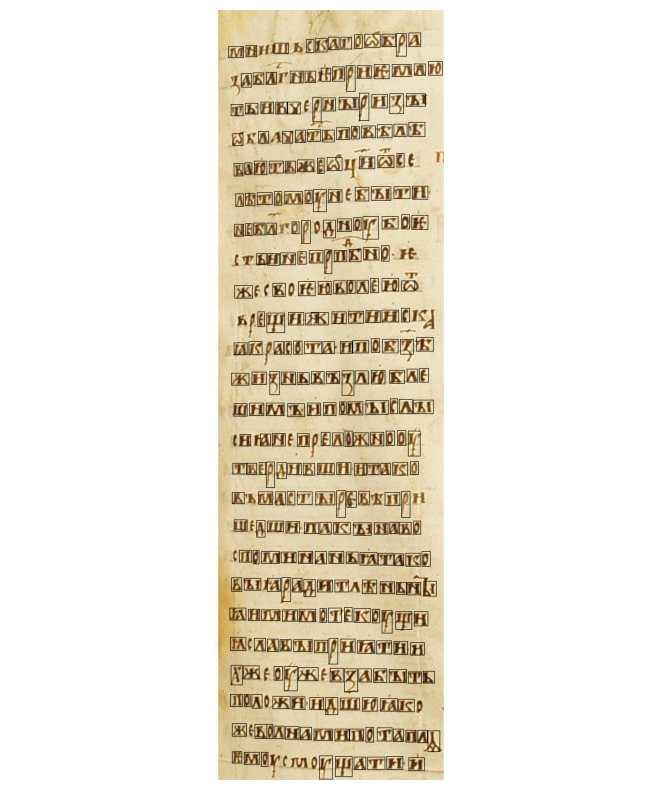

In [ ]:
for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        class_id = int(box.cls[0])
        confidence = box.conf[0]
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 0), 1)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()